In [1]:
from matplotlib import use
use('Agg')
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
from os import chdir, listdir
from pickle import load, dump
import ete3
from ete3.treeview.faces import add_face_to_node
import matplotlib.colors as colors
import matplotlib.cm as cmx
from PyQt5 import QtGui
import seaborn as sns
from itertools import combinations
import multiprocessing
from scipy.stats import pearsonr
from colormap import rgb2hex
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline
%cd ~/t3ss_effectors/

/Users/thiberio/t3ss_effectors


In [2]:
#
# load previously processed variables
#
# dictionary of homologous groups containing which genomes are present and their respective proteins
#   groups = { 'group1': { 'genome':[ proteins ] } }
groups = load(open('homologous_groups-merged.pkl', 'rb'))

# list of groups identified as part of T3SS
descriptions = {}
for group, desc in load( open('homologous_groups_descriptions-merged.pkl', 'rb') ).items():
        descriptions[ group.replace('&', '-') ] = desc 

new_descriptions = [ 
    '320898_93602.956    PteA'.split(),
    '321039_93602.2082-165230_103.4199   PteB'.split(),
    '70973_26797.2799    PteC'.split(),
    '274108_35496.2207   PteD'.split(),
    '198566_18299.3085   PteD.1'.split(),
    '11043_35.2670   PteE'.split(),
    '70378_26797.2204    PteF'.split(),
    '70959_26797.2785    PteG'.split(),
    '196098_18299.617    PteH'.split(),
    '3540_642.148.peg.3542   PteI'.split(),
    '274736_35496.2835   PteJ'.split(),
    '1896_642.148.peg.1898   PteK'.split(),
    '722_642.148.peg.724 PteL'.split(),
    '32734_39.4258   PteM'.split(),
    '290540_38.2655  PteM.1'.split(),
    '233145_42949.4186   Ati2'.split(),
    '253597_642.133.peg.2831-253599_642.133.peg.2833-7479_50.3400-253600_642.133.peg.2834-253596_642.133.peg.2830-256111_642.134.peg.949 AexT'.split(),
    '320085_93602.2233-333379_41.3491    AexU'.split(),
    '321199_93602.2926   AopX'.split(),
    '248323_67.1996-233200_42949.4241-248324_67.1997 AopO'.split(),
    '7135_50.3056    AopH'.split(),
    '252396_642.133.peg.1627-245405_42950.3198   AopS'.split()
]
        
#new_descriptions = [ ['70959_26797.2785' ,'axoU'],      ['252396_642.133.peg.1627-245405_42950.3198' ,'aopS'], 
#                     ['70378_26797.2204' ,'aopT'],      ['70973_26797.2799' ,'aseG'], 
#                     ['321199_93602.2926' ,'aopX'],     ['722_642.148.peg.724' ,'aopQ'], 
#                     ['320898_93602.956' ,'ateA'],      ['321039_93602.2082-165230_103.4199' ,'ateB'], 
#                     ['1896_642.148.peg.1898' ,'aopH2'],['242127_46596.4542','None'],
#                     ['321038_93602.2081', 'atcB'],     ['274108_35496.2207', 'tccC3'],
#                     ['198566_18299.3085', 'tccC3'] ]

descriptions['253598_642.133.peg.2832'] = 'None'
descriptions['242127_46596.4542']       = 'None'
for group, desc in new_descriptions:
    descriptions[group] = desc
                                                                                                    
#revised_effector_descriptions = set( ['aexu', 'aopx',  'ateb', 'atea',
#                                      'aext', 'aoph2', 'aoph', 'axou',
#                                      'ati2', 'tccc3', 'aopo', 'aseg',
#                                      'aops', 'aopq',  'aopt', 'xopac',
#                                      'spvb', 'exoy',  'ospf', 'exou'] )
revised_effector_descriptions = set([x[1].lower() for x in new_descriptions])

true_positive_effectors  = []
for group in descriptions.keys():
    if descriptions[group].lower() in revised_effector_descriptions:
        true_positive_effectors.append(group)

pa = pd.read_table( 'presence_absence-merged.tab', index_col=0 )
presence_absence = pd.read_table( 'presence_absence-merged.tab', index_col=0 )
presence_absence = presence_absence.reindex( columns=true_positive_effectors )

In [3]:
description_pa                = pd.DataFrame(index=presence_absence.index,
                                             columns=revised_effector_descriptions, data=0)
for group in true_positive_effectors:
    present_in_genomes = presence_absence[presence_absence[group] == 1].index
    description_pa.loc[present_in_genomes, descriptions[group].lower()] = [1] * len(present_in_genomes)

aopP_pa = []
for genome in description_pa.index:
    if genome in ['A_salmonicida_01B526', 'A_salmonicida_smithia_CIP104757',
                  'A_salmonicida_masoucida_CIP103210', 'A_salmonicida_achromogenes_CIP104001',
                  'A_salmonicida_CIP103209T', 'A_salmonicida_AS03']:
        aopP_pa.append(1)
    else:
        aopP_pa.append(0)
description_pa.loc[:, 'aopp'] = pd.Series( data=aopP_pa, index=description_pa.index)

In [4]:
sources       = pd.read_table('isolation_sources', index_col=0)
source_groups = sources.groupby('Isolation_sources')
sources       = sources['Isolation_sources']

In [5]:
#
# ...previously done
#
#true_positives = load( open( 'true_positives.pkl' ) )
#hmm_positives = load( open( 'hmm_positives.pkl' ) )
#merged_groups_desc = {}
#for group in t6ss_groups:
#    if group in true_positives:
#        merged_groups_desc[group] = hmm_positives[group]['desc']
#    else:
#        tmp_desc = set()
#        for tmp_group in group.split('-'):
#            if tmp_group == '14650_42938.2104' or tmp_group == '323223_93603.1872':
#                tmp_group = '14650_42938.2104-323223_93603.1872'
#            tmp_desc.add(hmm_positives[tmp_group]['desc'])
#        if len(tmp_desc) != 1:
#            print 'whaaaaat?'
#            break
#        else:
#            merged_groups_desc[group] = hmm_positives[tmp_group]['desc']
#out = open('homologous_groups_descriptions-merged.pkl', 'wb')
#dump(merged_groups_desc, out)
#out.close()

merged_groups_desc = load( open( 'homologous_groups_descriptions-merged.pkl', 'rb') )

In [6]:
apparatus = open('apparatus_occurrence').read()
apparatus = apparatus.split('\n')
apparatus.pop()
apparatus = [line.split('\\t') for line in apparatus]
for position, line in enumerate(apparatus):
    if len(line) == 1:
        line.append('')
apparatus = np.asarray(apparatus)

apparatus_df = pd.DataFrame(
    columns=['1', '2'],
    index  =apparatus[:,0],
    data   =0)
for line in apparatus:
    if not line[1]:
        continue
    for value in apparatus_df.columns:
        if value in line[1]:
            apparatus_df.loc[line[0], value]  = 1

description_pa['T3SSI']  = apparatus_df['1']
description_pa['T3SSII'] = apparatus_df['2']

In [21]:
def pearson_wrapper(value):
    x,y = value
    return list(pearsonr(x,y))

pool = multiprocessing.Pool(processes=10)
pearson_output = pool.map(pearson_wrapper, list( combinations(description_pa.T.values, 2)) )
pool.close()
pool.join()

pearson_output = np.asarray(pearson_output)
reject, corrected_p, alphacSidak, alphacBonf = multipletests(pearson_output[:, 1], method='fdr_bh')

r = distance.squareform(pearson_output[:, 0]).copy()
p = distance.squareform(pearson_output[:, 1]).copy()
q = distance.squareform(corrected_p).copy()

r_df = pd.DataFrame(data=r, index=description_pa.columns, columns=description_pa.columns)
mask = q > 0.05

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


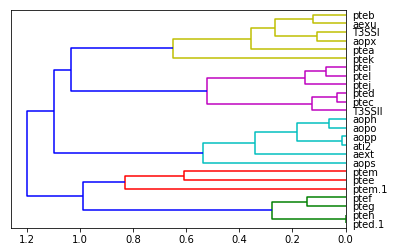

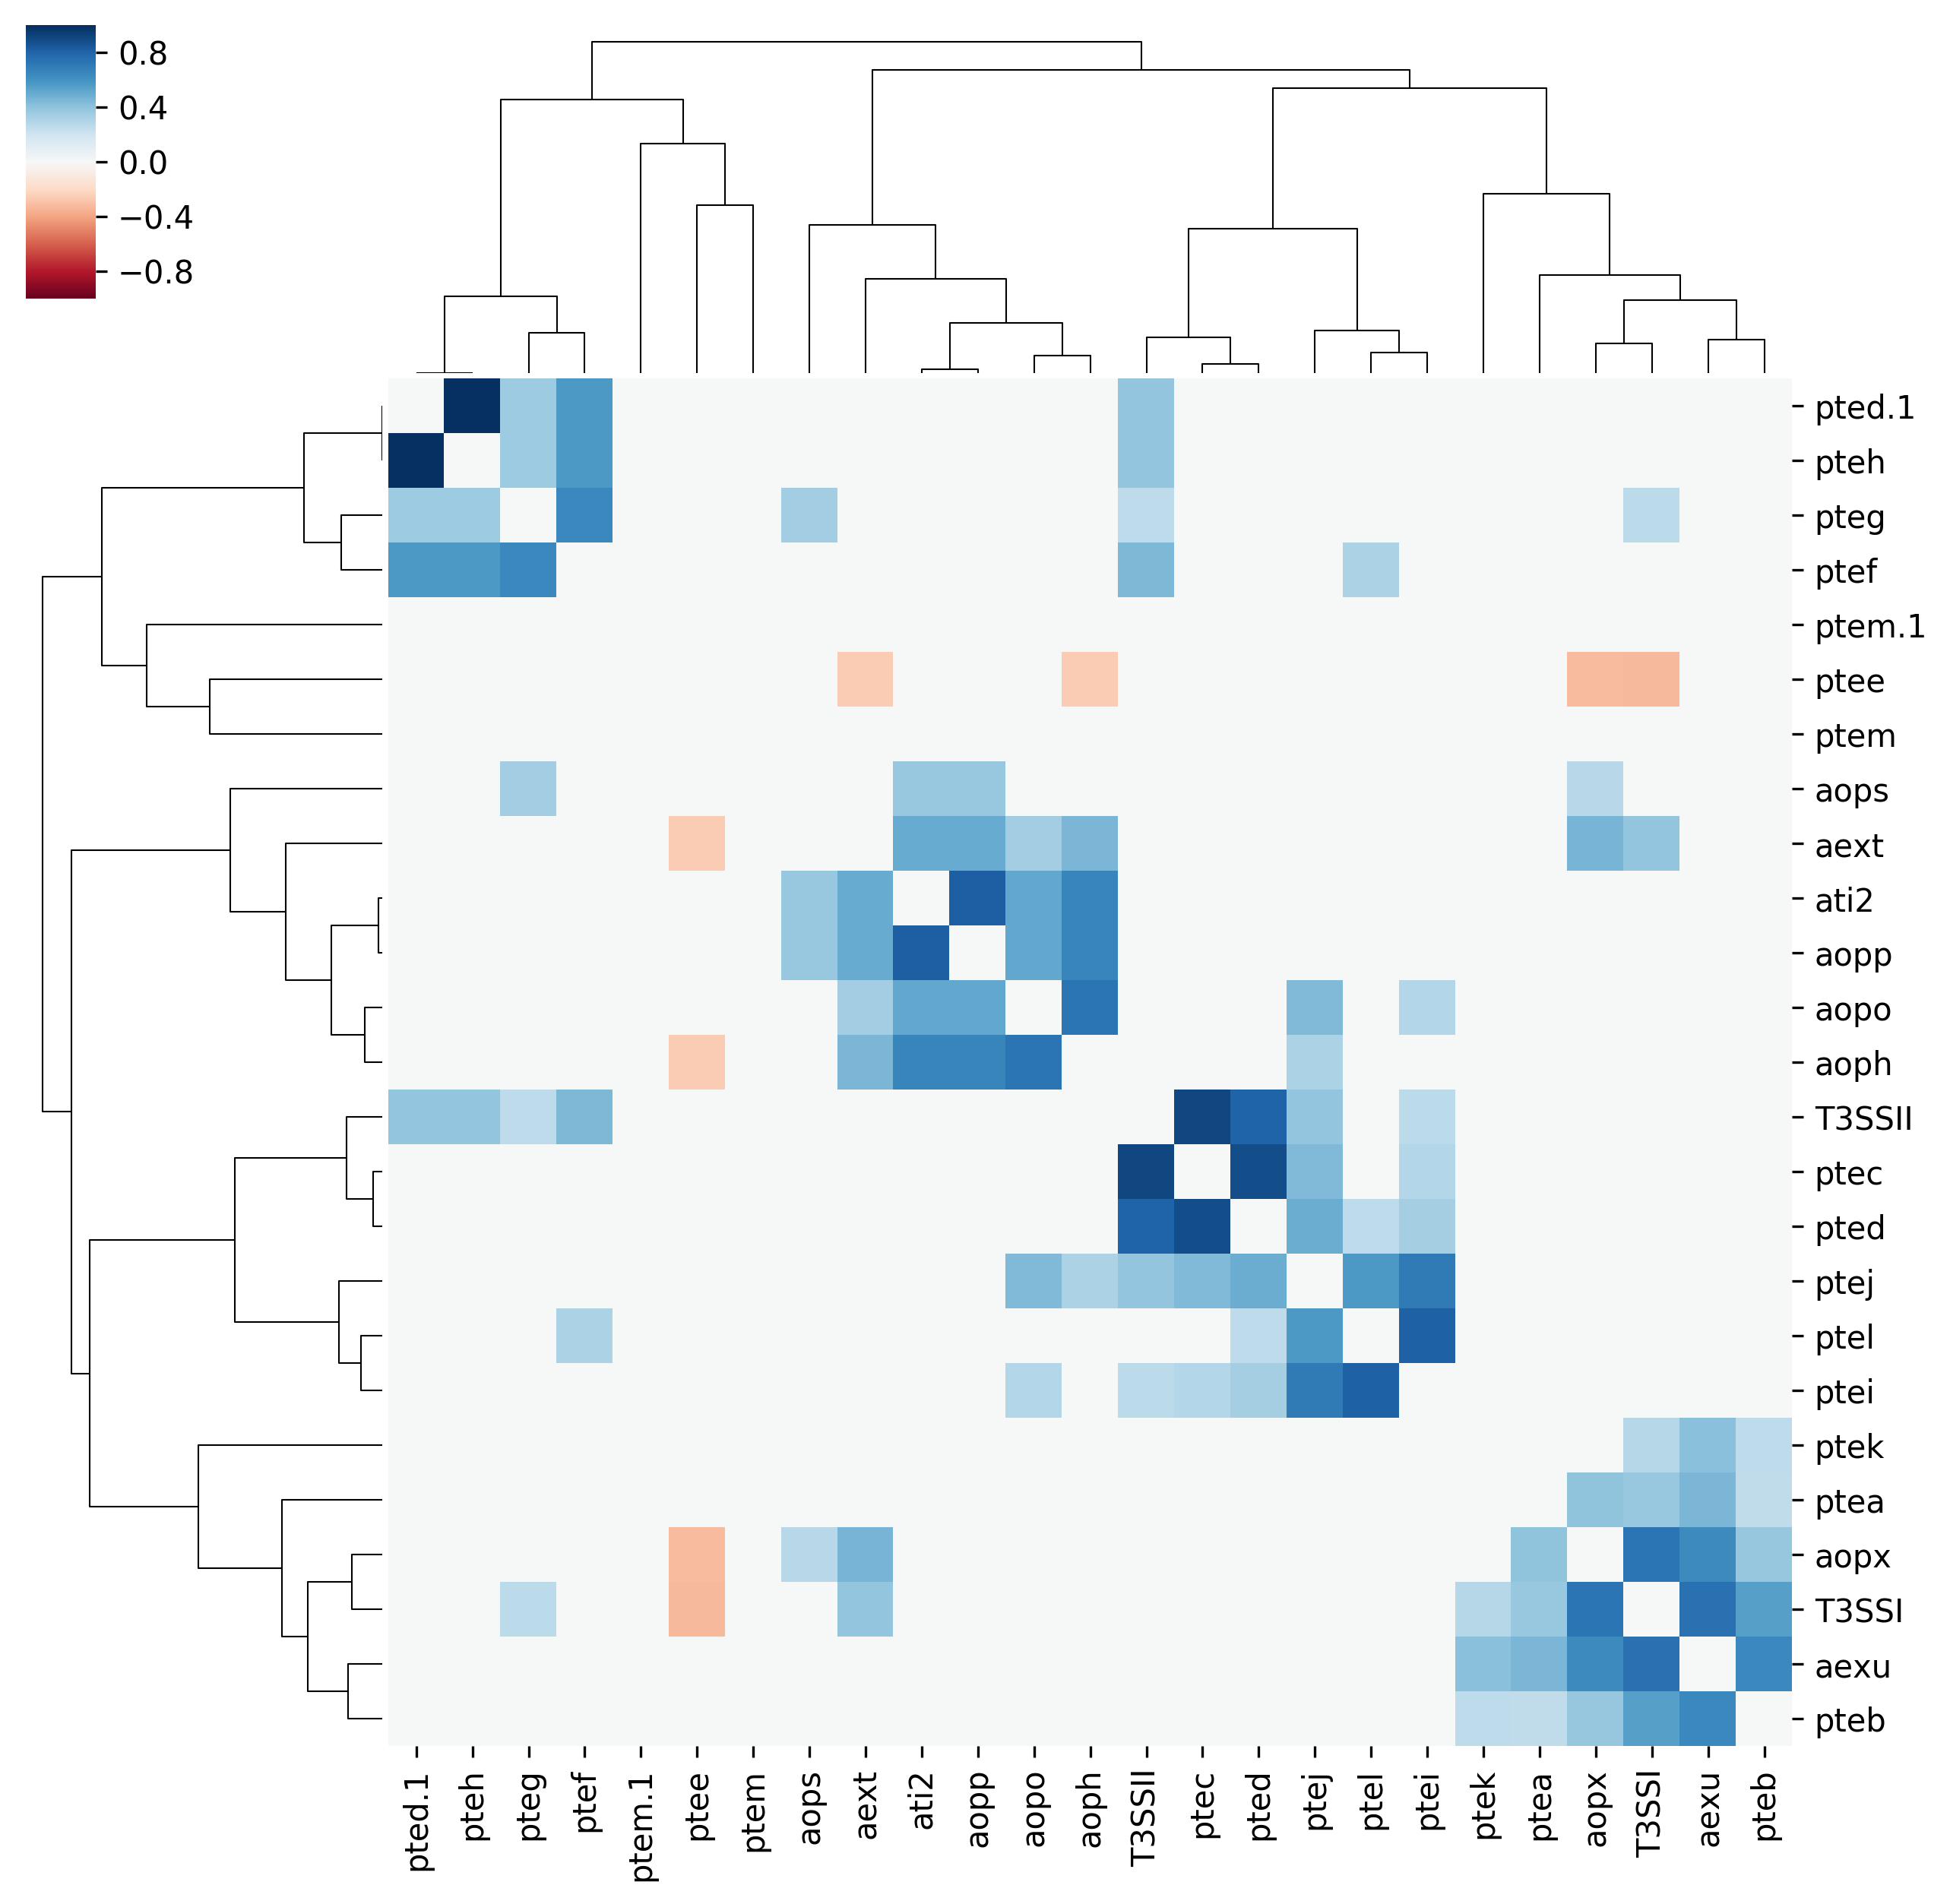

In [23]:
effectors_dist = distance.squareform( distance.pdist( description_pa.T, 'correlation' ) )
effectors_clst = sch.linkage( effectors_dist, method='average', metric='correlation' )
effectors_dend = sch.dendrogram( effectors_clst, labels=description_pa.columns, orientation='left' )

r[mask] = 0
tmp_map = pd.DataFrame( data=r, columns=description_pa.columns, index=description_pa.columns )

fig = sns.clustermap(tmp_map, cmap='RdBu', metric='correlation',
                     method='average', row_linkage=effectors_clst,
                     col_linkage=effectors_clst, vmax=1, vmin=-1)
fig.fig.set_dpi(300)
fig.fig.set_size_inches([10,10])
fig.fig.tight_layout()
fig.fig.savefig('S1 Figure.pdf', dpi=600)

In [9]:
sorted_effectors = []
for position in effectors_dend[ 'leaves' ]:
    sorted_effectors.append( description_pa.columns[ position ] )

sorted_effectors.remove('T3SSI')
sorted_effectors.remove('T3SSII')
sorted_effectors = ['T3SSI', 'T3SSII']+sorted_effectors

description_pa = description_pa.reindex(columns=sorted_effectors)
r_df = r_df.reindex(columns=sorted_effectors, index=sorted_effectors)

In [10]:
out = open('t3ss_effectors_descriptions-presence_absence.tab2', 'w')
out.write('#Names')
out.close()
description_pa.to_csv('t3ss_effectors_descriptions-presence_absence.tab2', sep='\t', mode='a')

In [11]:
def get_color_gradient(self):
    from PyQt5 import QtGui
    import matplotlib.colors as colors
    import matplotlib.cm as cmx

    cNorm  = colors.Normalize(vmin=0, vmax=1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap(self.colorscheme))
    color_scale = []
    for scale in np.linspace(0, 1, 201):
        hex_color = rgb2hex(*[int(n) for n in scalarMap.to_rgba(scale)[:3]])
        #hex_color = '#%02x%02x%02x' %tuple(scalarMap.to_rgba(scale)[:3])
        [r,g,b,a] = scalarMap.to_rgba(scale, bytes=True)
        color_scale.append( QtGui.QColor( r, g, b, a ) )

    return color_scale

ete3.ProfileFace.get_color_gradient = get_color_gradient

cNorm  = colors.Normalize(vmin=0, vmax=source_groups.ngroups)
scalarMap = cmx.ScalarMappable( norm=cNorm, cmap=plt.get_cmap('Paired') )
sourceColors = {'veterinary':'#309132',     #green
                'wound':'#AA44C1',          #purple
                'enviroment':'#003EFA',     #blue
                'sick veterinary':'#CCC500',#yellow
                'feces':'#F09000',          #orange
                'blood':'#F42A06',          #red
                'human':'#F90673' }         #pink
nameFaces = {}
sourceFaces = {}
for isolation_source in source_groups.groups:
    sourceFaces[isolation_source] = ete3.CircleFace(6, sourceColors[isolation_source])
    nameFaces[isolation_source] = ete3.AttrFace("name", fsize=10, fgcolor=sourceColors[isolation_source])

In [12]:
nameFace = ete3.AttrFace("name", fsize=10)
supportFace = ete3.AttrFace("support", fsize=10)
sourceFaces = {}
for isolation_source in source_groups.groups:
    sourceFaces[isolation_source] = ete3.CircleFace(6, sourceColors[isolation_source])
for genome, isolation_source in sources.items():
    sourceFaces[genome] = ete3.CircleFace(6, sourceColors[isolation_source])
new_aeromonas_names = pd.read_table( 'ThiberioHG_21Feb17.translate', index_col=0, header=None).squeeze()
def myLayout(node):
    heatmap = ete3.ProfileFace(1, 0.01, 0.5, description_pa.shape[1]*15, 14, "heatmap", colorscheme='Greys')

    if node.is_leaf():
        node_name = node.name.replace('.', '').replace(' ', '_')
        add_face_to_node(heatmap, node, 0, aligned=True)
        add_face_to_node(sourceFaces[node_name], node, 1, aligned=True)
        node.name = new_aeromonas_names[node_name]
        add_face_to_node(nameFace, node, 2, aligned=True)
        node.img_style['size'] = 0
    elif node.is_root():
        node.img_style['size'] = 0
    else:
        if node.support >= 95:
            node.img_style['size'] = 7
            node.img_style['fgcolor'] = '#791205'
        else:
            node.img_style['size'] = 0

In [32]:
tree = ete3.ClusterTree('RAxML_fastTreeSH_Support.sh_like-unrooted',
                        't3ss_effectors_descriptions-presence_absence.tab2')
aeromonas_outgroup = tree.get_common_ancestor('A_simiae_CIP107798T', 'A_schubertii_CECT4240T',
                                              'A_diversa_CECT4254T')

In [33]:
tree.set_outgroup( aeromonas_outgroup )
treeStyle                   = ete3.TreeStyle()
treeStyle.layout_fn         = myLayout
treeStyle.show_leaf_name    = False
treeStyle.draw_guiding_lines= True

In [34]:
#treeStyle.legend.add_face(ete3.TextFace('  Isolation sources:  ', fsize=20, fgcolor='black'), column=0)
#count = 1
#for isolation_source in source_groups.groups:
#    if count > 7:
#        count = 1
#    treeStyle.legend.add_face(ete3.TextFace('%s    ' %isolation_source, fsize=20,
#                              fgcolor=nameFaces[isolation_source].fgcolor), column=count)
#    count += 1
#treeStyle.legend_position = 3
#tree.render('%%inline', dpi=600,
#                      tree_style=treeStyle)
tree_plot=tree.render('tree_and_heatmap.pdf', dpi=600, tree_style=treeStyle)